In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rc('font', size=12)

from numba import njit

# Voter model with mutation, coalescence approach

In [2]:
def init_grid(L):
    '''Initialises an L by L grid with numbers drawn randomly from (0, 1)'''
    return np.random.rand(L, L)

In [3]:
def get_4_neighbors(i, j, L):
    '''Finds upper, lower, left and right neighbor of a site in a K by K grid'''
    neighbors = []
    # Up, down, right, left
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  
    for di, dj in directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [3]:
import itertools

def moore_neighborhood_directions(R):
    # Find coordinates of all neighbors within range R
    directions = list(itertools.product(range(-R, R + 1), range(-R, R + 1)))
    del directions[int(len(directions)/2)]

    return directions

In [4]:
def get_9_neighbors(i, j, L, moore_directions):
    '''Finds all surrounding neighbors of a site in a L by L grid (Moore neighborhood)'''
    neighbors = []

    for di, dj in moore_directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % L)
        neighbor_j = int((j + dj) % L)
        neighbors.append((neighbor_i, neighbor_j))
    return neighbors

In [5]:
import math

def get_neighbors_fattail(i, j, W, eta, moore_directions):
    ''' Computes fat-tailed dispersal kernel
    Parameters:
    - i: x-coordinate of center
    - j: y-coordinate of center
    - W: length scale or width of kernel
    - R: distance between parent and offspring
    - eta: defines "fatness" of the distribution

    Returns:
    - neighbors: list of all surrounding neighbors within range R
    - probabilities: list of all probabilities taken from a fat-tailed distribution given distance between center and neighbor
    '''

    neighbors = []
    probabilities = []

    # Find coordinates of neighbors within range R
    for di, dj in moore_directions:
        # Apply periodic boundary conditions
        neighbor_i = int((i + di) % W)
        neighbor_j = int((j + dj) % W)
        neighbors.append((neighbor_i, neighbor_j))

        # Calculate Euclidean distance between center and neighbor
        dist = math.dist([i, j], [neighbor_i, neighbor_j])

    # Calculate fat-tail probability
    for d in dist:
        K = -((eta + 2) / (2 * np.pi * w**2)) * (1 + ((d[0])/w)**2 )**(eta/2)
        probabilities.append(K)
        
    probabilities = np.array(probabilities) / sum(probabilities)
    return neighbors, probabilities

In [7]:
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances

def get_neighbors_gaussian(i, j, L, moore_directions):
    ''' Computes Gaussian dispersal kernel
    Parameters:
    - i: x-coordinate of center
    - j: y-coordinate of center
    - W: length scale or width of kernel
    - R: distance between parent and offspring

    Returns:
    - neighbors: list of all surrounding neighbors within range R
    - probabilities: list of all probabilities taken from a Gaussian distribution given distance between center and neighbor
    '''

    neighbors = []
    probabilities = []

    # Find coordinates of all neighbors within range R
    for dir in moore_directions:
        neighbors.append(tuple(map(lambda x, y: (x + y) % L, dir, (i, j))))

    dist = euclidean_distances(neighbors, [[i,j]])
        
    for d in dist:
        probabilities.append(float(stats.norm.pdf(d, 0, 1)))
    
    probabilities = np.array(probabilities) / sum(probabilities)

    return neighbors, probabilities

In [8]:
def sa_curve(grid):
    height, width = grid.shape
    
    n_centers = 10
    centers_x = np.random.choice(np.arange(0, width), n_centers) + width
    centers_y = np.random.choice(np.arange(0, height), n_centers) + height

    areas = []
    species = []
    
    torus_grid = np.vstack((grid, grid, grid))
    torus_grid = np.hstack((torus_grid, torus_grid, torus_grid))
        
    for i, (x, y) in enumerate(zip(centers_x, centers_y)):
        cur_species = []
        for j in range(width//2):
            cur_species.append(len(np.unique(torus_grid[x-j:x+j+1, y-j:y+j+1])))
            if i == 0:
                areas.append((j+1)**2)
        species.append(cur_species)
    
    return areas, species

In [8]:
import random
import itertools
from tqdm import tqdm
import time
import sys

def voter_model_fast(L, alpha, kernel='nearest', W=3, eta=-1):
    '''Run experiment with the voter model
    Inputs:
    grid_0 (numpy array): Initial grid
    alpha (float): Value of alpha parameter
    MC_steps (int): number of monte carlo steps
    
    Returns:
    cur_grid (numpy array): Grid after n_iter iterations
    num_species (list): Contains amount of different species at each tenth iteration
    '''
    # Create list to store number of unique species
    lineages = [set() for _ in range(len(rand_walkers))]
    for i, element in enumerate(rand_walkers):
        lineages[i].add(element)

    rand_walker_pos = list(rand_walkers.copy())
    species = []
    
    for i in range(MC_steps):
        # Draw full list of random numbers to save time
        rand_nums = np.random.uniform(size=L**2)
        for j in tqdm(range(L**2)):
            if len(rand_walker_pos) == 0:                
                return lineages, species
            
            # Select active walker
            cur_walker_loc = np.random.choice(len(rand_walker_pos))
            cur_walker = rand_walker_pos[cur_walker_loc]
            # Find current walker's place in lineages
            cur_walker_idx = L*cur_walker[0] + cur_walker[1]

            if kernel in ['fat tail', 'gaussian', 'nearest_moore']:    
                moore_directions = moore_neighborhood_directions(D)
            
            # Select parent
            if kernel == 'nearest':
                potential_parents = get_4_neighbors(cur_walker[0], cur_walker[1], L)
                parent_walker_loc = np.random.choice(len(potential_parents))
                parent_walker = potential_parents[parent_walker_loc]
            elif kernel == 'gaussian':
                potential_parents, probabilities = get_neighbors_gaussian(cur_walker[0], cur_walker[1], L, moore_directions)
                parent_walker_loc = np.random.choice(len(potential_parents), p=probabilities)
                parent_walker = potential_parents[parent_walker_loc]
            elif kernel == 'fat tail':
                potential_parents, probabilities = get_neighbors_fattail(cur_walker[0], cur_walker[1], W, eta, moore_directions)
                parent_walker_loc = np.random.choice(len(potential_parents), p=probabilities)
                parent_walker = potential_parents[parent_walker_loc]
                
            # Find parent's place in lineages
            parent_walker_idx = L*parent_walker[0] + parent_walker[1]
            
            # Speciate with probability alpha
            speciate = False
            if rand_nums[j] < alpha:
                speciate = True
                species.append(lineages[cur_walker_idx])
                # Insert pointer to correct species where the walker is in
                for site in lineages[cur_walker_idx]:
                    site_idx = L*site[0] + site[1]
                    lineages[site_idx] = len(species) - 1                
            else:
                # Check if parent hasn't speciated yet
                if type(lineages[parent_walker_idx]) == set:
                    # Merge lineages if walkers are from other walks
                    if parent_walker not in lineages[cur_walker_idx]:
                        # Unify lineages of parent and child
                        lineages[cur_walker_idx] = lineages[cur_walker_idx].union(lineages[parent_walker_idx])
                        for site in lineages[cur_walker_idx]:
                            site_idx = L*site[0] + site[1]
                            lineages[site_idx] = lineages[cur_walker_idx]
                            
                        for site in lineages[parent_walker_idx]:
                            site_idx = L*site[0] + site[1]
                            if type(lineages[site_idx]) == set:
                                lineages[site_idx] = lineages[cur_walker_idx]
                                
                    # Handle case when walker has moved back into its own lineage
                    else:
                        # Change position of active walker
                        if parent_walker not in rand_walker_pos:
                            rand_walker_pos.append(parent_walker)
                # Let speciation occur
                elif type(lineages[parent_walker_idx]) == int:
                    species[lineages[parent_walker_idx]] = species[lineages[parent_walker_idx]].union(lineages[cur_walker_idx])
                    for site in lineages[cur_walker_idx]:
                        site_idx = L*site[0] + site[1]
                        lineages[site_idx] = lineages[parent_walker_idx]
            
            # Remove current walker from list of active walkers
            rand_walker_pos.remove(cur_walker)

    return species

Text(0.5, 1.0, 'Fat tail distribution (eta=-4)')

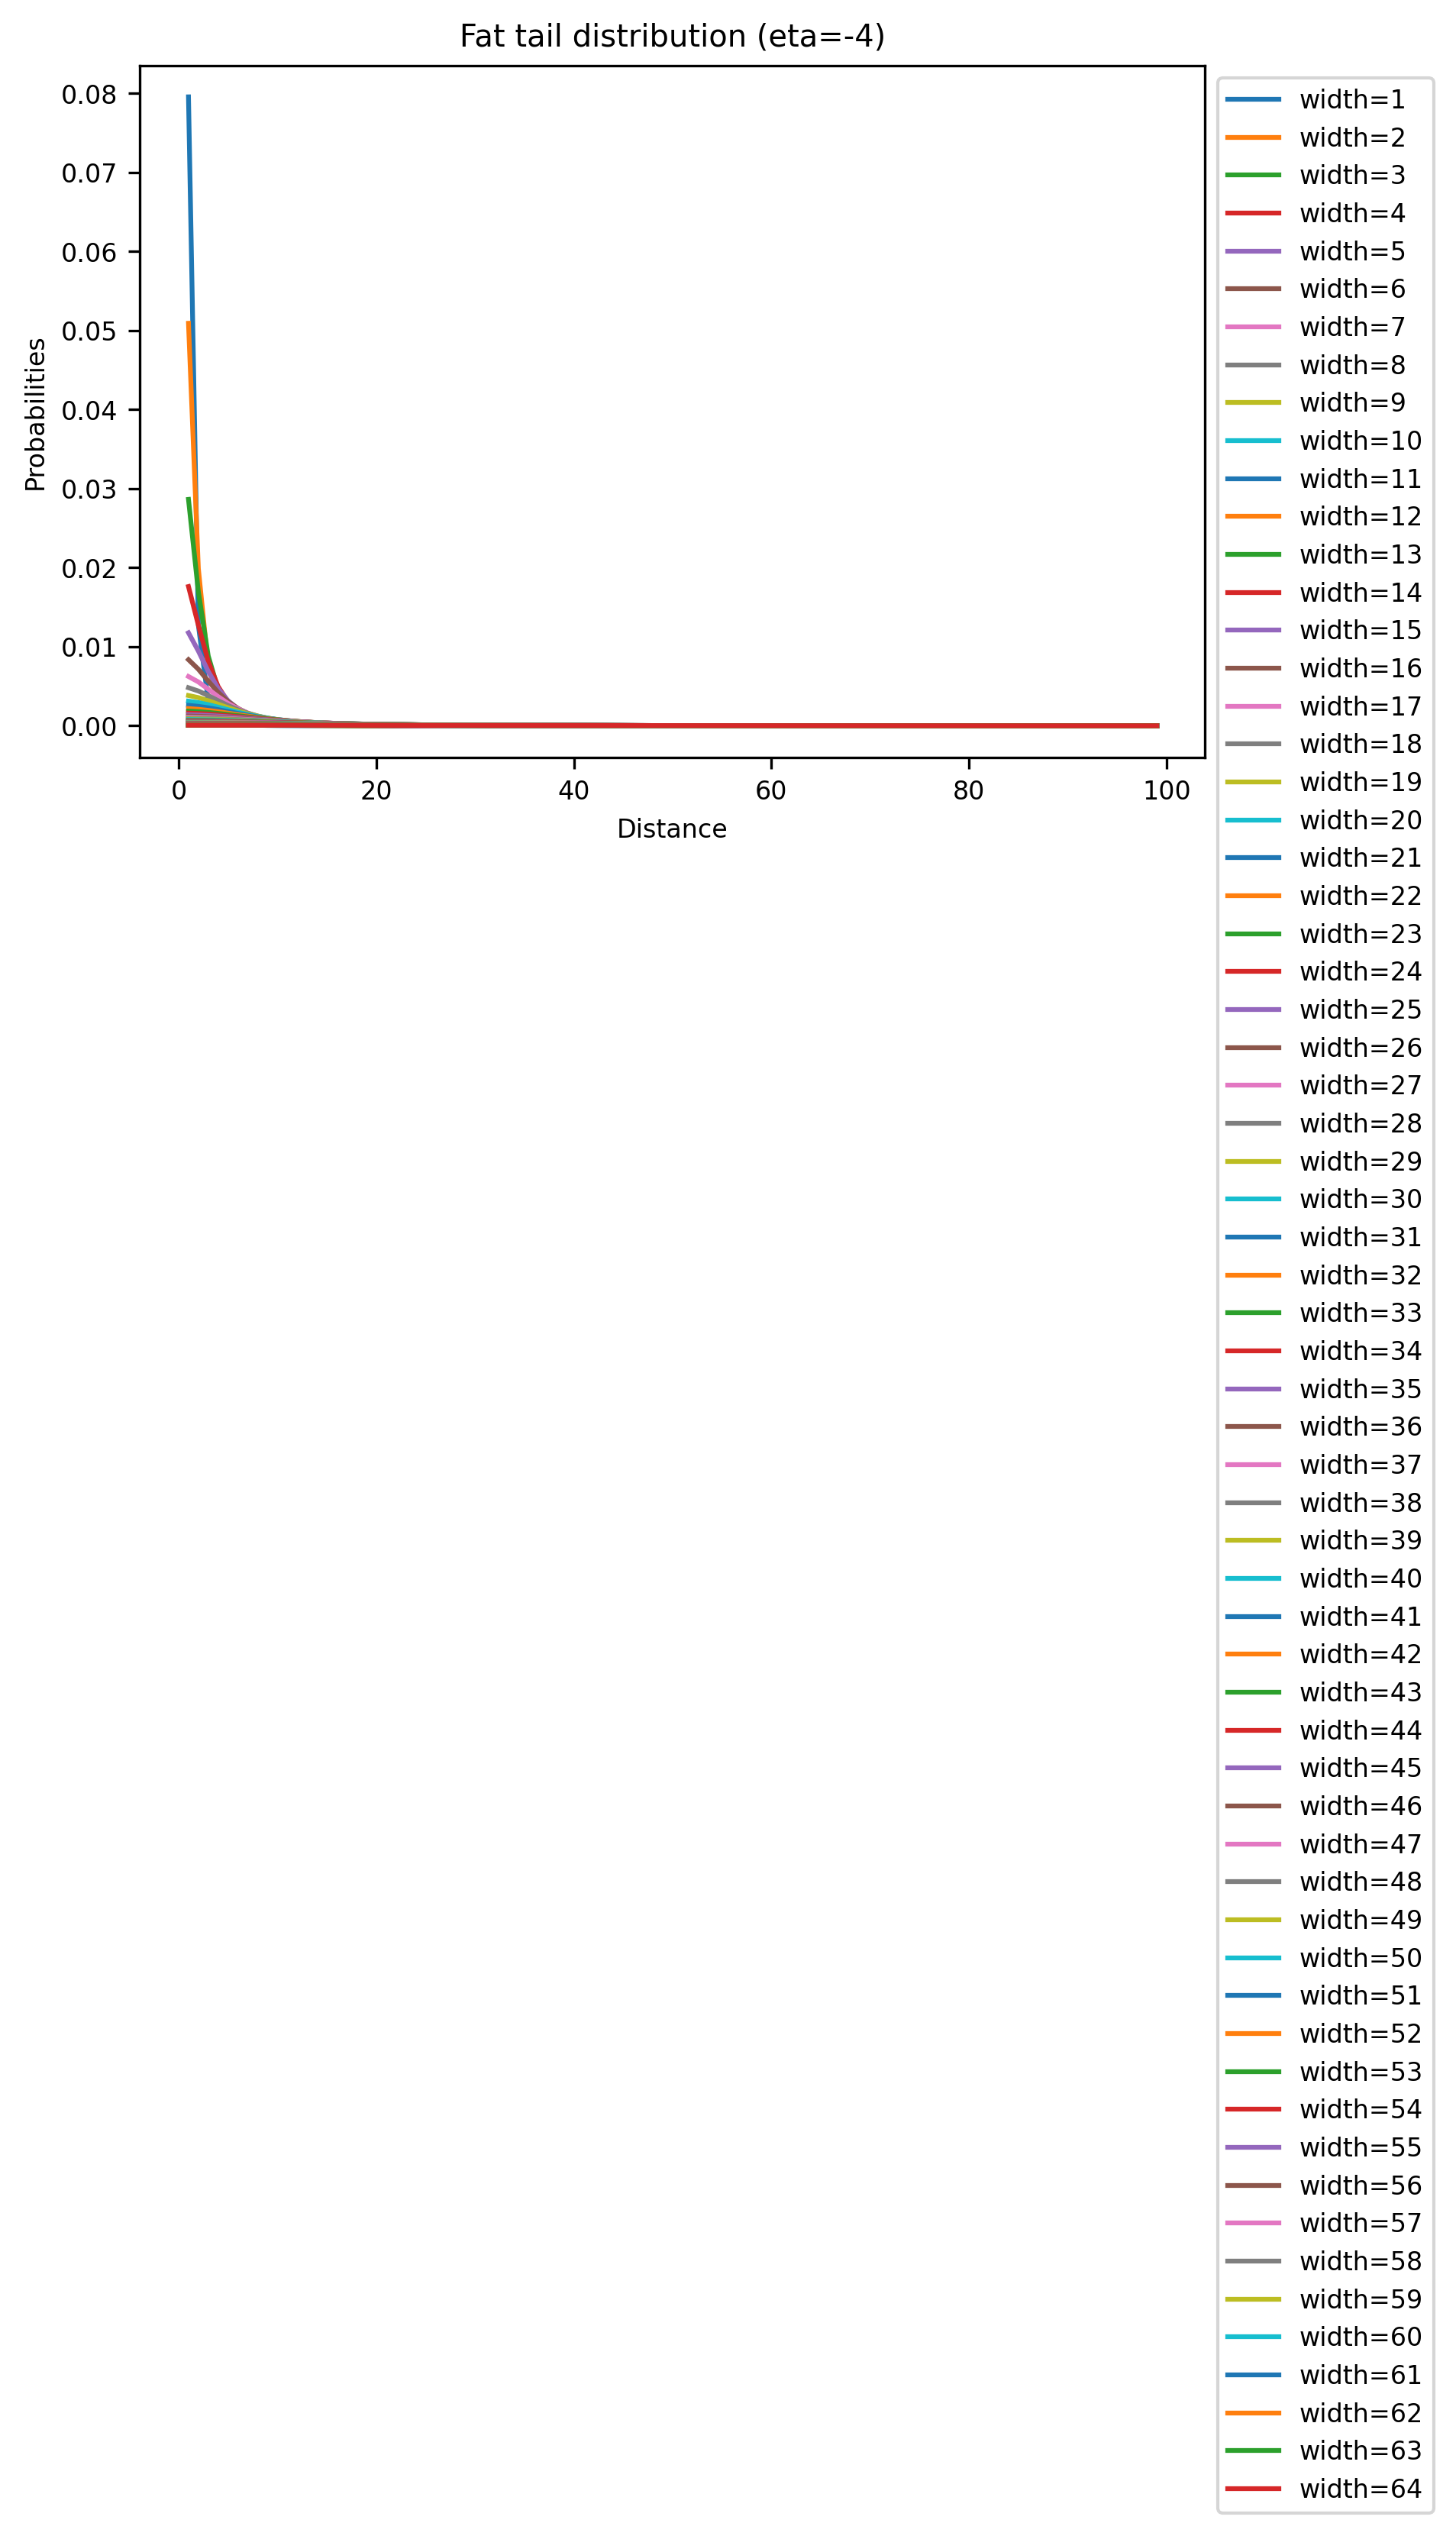

In [ ]:
eta = -4
width = range(1,65)
dist = range(1,100)

for w in width:
    probs = []
    for d in dist:
        K = -((eta + 2) / (2 * np.pi * w**2)) * (1 + ((d)/w)**2 )**(eta/2)
        probs.append(K)

    plt.plot(dist, probs,label=f'width={w}')

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Distance')
plt.ylabel('Probabilities')
plt.title(f'Fat tail distribution (eta={eta})')


Text(0.5, 1.0, 'Fat tail distribution (width=32)')

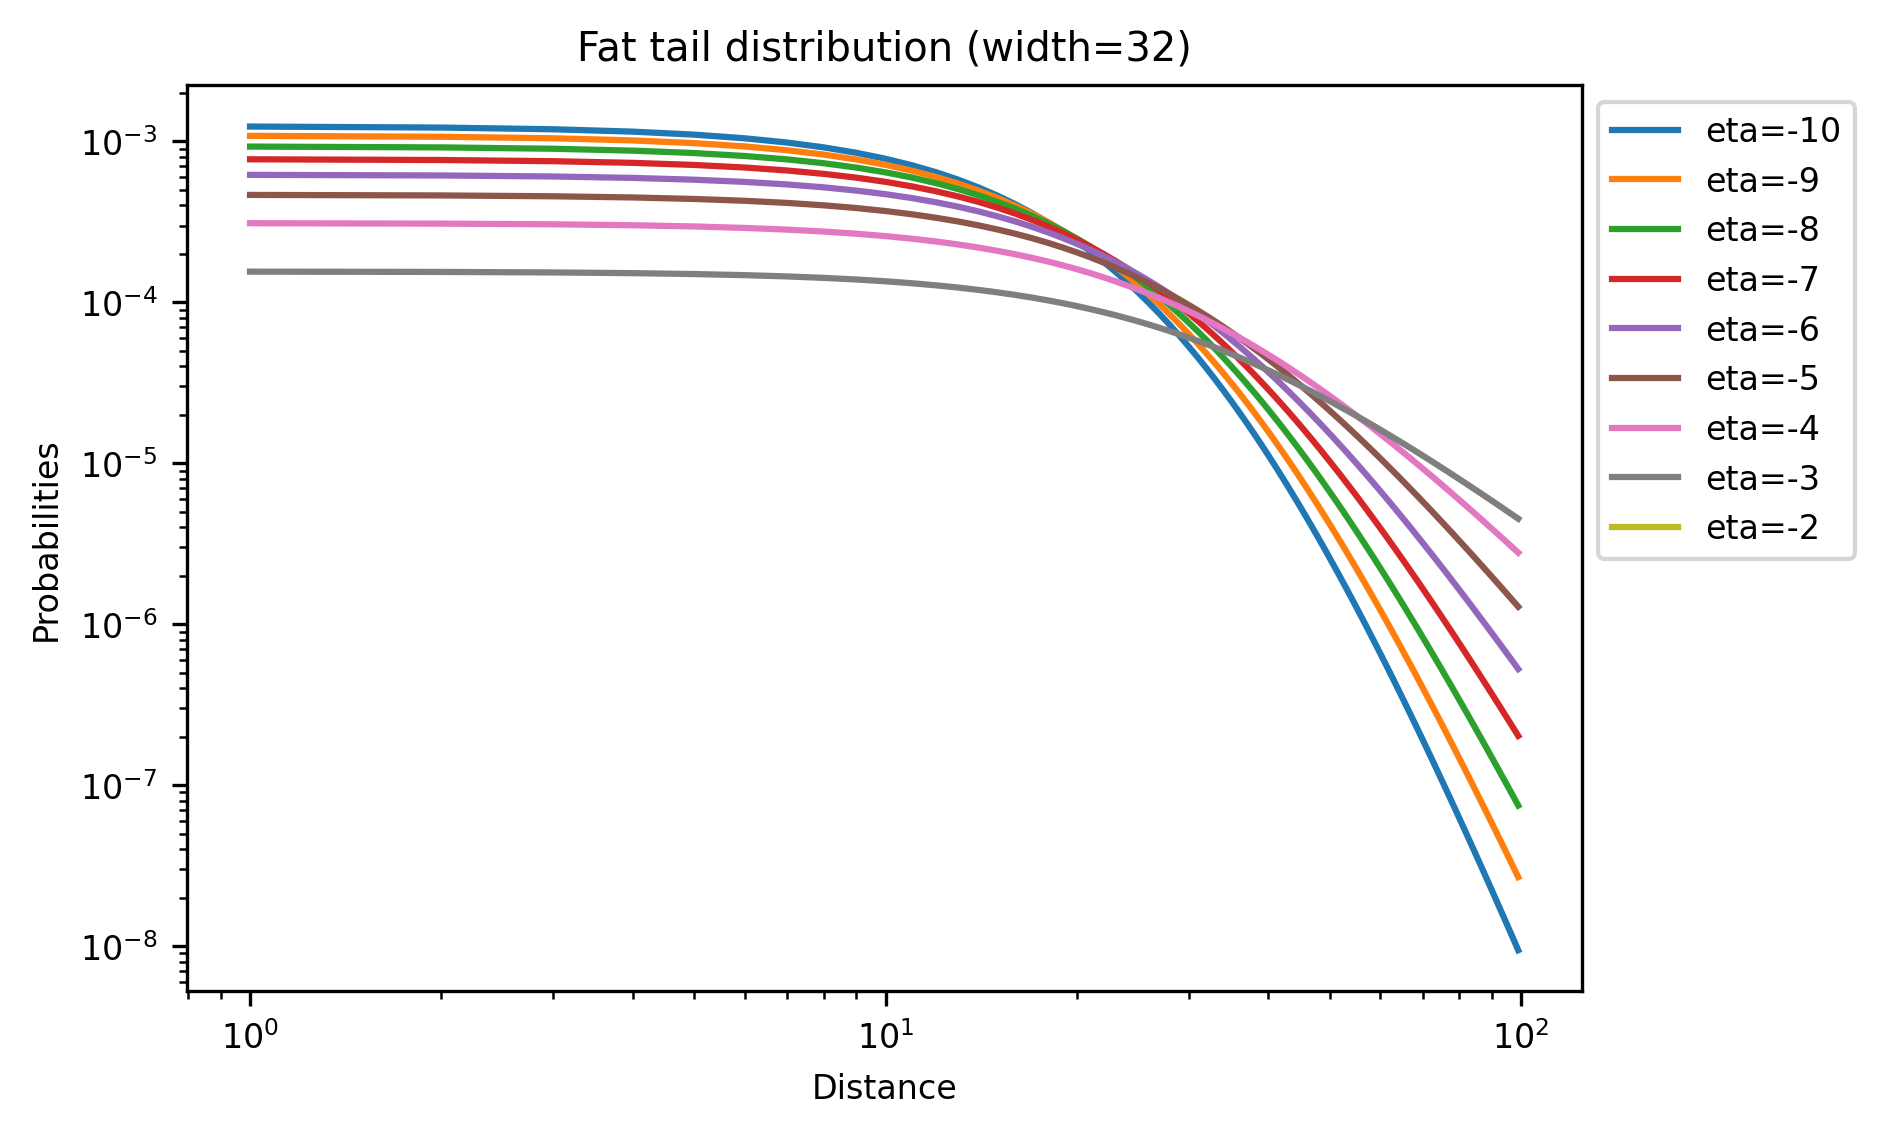

In [24]:
etas = range(-10,-1)
w = 32
dist = range(1,100)

for eta in etas:
    probs = []
    for d in dist:
        K = -((eta + 2) / (2 * np.pi * w**2)) * (1 + ((d)/w)**2 )**(eta/2)
        probs.append(K)

    plt.loglog(dist, probs,label=f'eta={eta}')

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Distance')
plt.ylabel('Probabilities')
plt.title(f'Fat tail distribution (width={w})')
